# Lab 5: Inception V3 CNN for Animal Image Classification

This notebook implements the Inception V3 Convolutional Neural Network architecture for classifying images from the Animals10 dataset. Inception V3 is an advanced CNN architecture that uses asymmetric filters of small size and 1x1 convolutions to minimize computational costs while maintaining network generalization power.

## Apple Silicon (M1/M2) GPU Support

This notebook has been configured to utilize the GPU on Apple Silicon (M1/M2) Macs using TensorFlow's Metal Performance Shaders (MPS) backend. Here are some important notes:

1. **Requirements**:
   - TensorFlow 2.5+ with MPS support (ideally 2.9+ for better performance)
   - macOS 12.0+ (Monterey or later)
   - Python 3.8+

2. **Setup Instructions**:
   - Make sure you have the latest version of TensorFlow installed: `pip install tensorflow>=2.9.0`
   - For optimal performance, install the tensorflow-metal plugin: `pip install tensorflow-metal`
   - No CUDA or cuDNN installation is needed for Apple Silicon

3. **Troubleshooting**:
   - If you encounter errors with MPS, you can fall back to CPU by removing the `with tf.device('/device:MPS:0'):` contexts
   - Some operations may not be supported by MPS yet and will automatically fall back to CPU
   - Monitor your GPU usage with Activity Monitor (look for "Metal" processes)

The code will automatically detect if MPS is available and use it for model creation, training, evaluation, and prediction. If MPS is not available, it will fall back to CPU.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import time
import glob
from tensorflow.keras.utils import to_categorical
import random
from PIL import Image
import requests
import zipfile
import io

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to detect GPU type and availability
def detect_gpu():
    import platform
    import subprocess
    import sys

    gpu_info = {
        "tensorflow_version": tf.__version__,
        "has_gpu": False,
        "gpu_type": "None",
        "is_apple_silicon": False,
        "apple_chip_model": "None",
        "has_neural_engine": False,  # New field for Neural Engine
        "dedicated_gpu": False,
        "gpu_details": []
    }

    # Check for CUDA GPUs (NVIDIA)
    cuda_devices = tf.config.list_physical_devices('GPU')
    if cuda_devices:
        gpu_info["has_gpu"] = True
        gpu_info["gpu_type"] = "CUDA (NVIDIA)"
        gpu_info["dedicated_gpu"] = True
        gpu_info["gpu_details"] = [device.name for device in cuda_devices]
        print(f"CUDA GPU Available: {cuda_devices}")

    # Check for Apple Silicon (M1/M2/M3) GPU
    system = platform.system()
    if system == "Darwin":  # macOS
        # Check if running on Apple Silicon
        try:
            # Check processor type
            processor = platform.processor()
            if processor == "arm":
                gpu_info["is_apple_silicon"] = True

                # Try to get more specific chip information
                try:
                    # Use sysctl to get chip model
                    result = subprocess.run(['sysctl', '-n', 'machdep.cpu.brand_string'], 
                                           capture_output=True, text=True, check=True)
                    chip_info = result.stdout.strip()
                    if "Apple M" in chip_info:
                        gpu_info["apple_chip_model"] = chip_info
                        print(f"Apple Silicon detected: {chip_info}")

                        # All M-series chips have Neural Engine
                        gpu_info["has_neural_engine"] = True
                        print("Neural Engine is available")

                        # Check if coremltools is installed
                        try:
                            import coremltools
                            print(f"Core ML Tools version: {coremltools.__version__}")
                        except ImportError:
                            print("Core ML Tools not installed. Install with: pip install coremltools")
                except:
                    print("Apple Silicon detected, but couldn't determine specific model")

                # Check if MPS (Metal Performance Shaders) is available
                try:
                    if tf.config.list_physical_devices('MPS'):
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "MPS (Apple Silicon)"
                        print("MPS (Apple Silicon GPU) is available")

                        # Try to enable MPS
                        physical_devices = tf.config.list_physical_devices('MPS')
                        if physical_devices:
                            tf.config.experimental.set_visible_devices(physical_devices[0], 'MPS')
                            print("MPS device enabled")
                    else:
                        # Alternative way to check for MPS availability
                        mps_available = tf.config.list_physical_devices('GPU')
                        print(f"MPS (Apple Silicon GPU) built with MPS: {mps_available}")

                        if mps_available:
                            gpu_info["has_gpu"] = True
                            gpu_info["gpu_type"] = "MPS (Apple Silicon)"

                            # Configure TensorFlow to use the MPS backend
                            physical_devices = tf.config.list_physical_devices('MPS')
                            if physical_devices:
                                tf.config.experimental.set_visible_devices(physical_devices[0], 'MPS')
                                print("MPS device enabled")
                            else:
                                print("No MPS devices found despite MPS being available")
                except Exception as e:
                    print(f"Error checking MPS availability: {e}")
        except Exception as e:
            print(f"Error detecting Apple Silicon: {e}")

    # Print summary
    print("\nGPU Detection Summary:")
    print(f"- TensorFlow version: {gpu_info['tensorflow_version']}")
    print(f"- GPU available: {gpu_info['has_gpu']}")
    print(f"- GPU type: {gpu_info['gpu_type']}")
    print(f"- Is Apple Silicon: {gpu_info['is_apple_silicon']}")
    if gpu_info['is_apple_silicon']:
        print(f"- Apple chip model: {gpu_info['apple_chip_model']}")
        print(f"- Has Neural Engine: {gpu_info['has_neural_engine']}")
    print(f"- Has dedicated GPU: {gpu_info['dedicated_gpu']}")
    if gpu_info['gpu_details']:
        print(f"- GPU details: {gpu_info['gpu_details']}")

    return gpu_info

# Detect GPU
gpu_info = detect_gpu()

# If no GPU is available, print a message
if not gpu_info["has_gpu"]:
    print("No GPU detected. Falling back to CPU.")

def convert_to_coreml(model, input_shape, class_names):
    """
    Convert TensorFlow model to Core ML format for Neural Engine acceleration

    Args:
        model: TensorFlow Keras model
        input_shape: Input shape tuple (height, width, channels)
        class_names: List of class names for classification

    Returns:
        Path to saved Core ML model
    """
    try:
        import coremltools as ct
        from coremltools.models.neural_network import quantization_utils

        print("Converting TensorFlow model to Core ML format...")

        # Define input shape for Core ML
        input_shape_dict = {'input_1': input_shape}

        # Convert to Core ML model
        mlmodel = ct.convert(
            model, 
            inputs=[ct.ImageType(name='input_1', shape=input_shape, scale=1/255.0, bias=[0, 0, 0])],
            classifier_config=ct.ClassifierConfig(class_names),
            compute_precision=ct.precision.FLOAT16,  # Use FP16 for better Neural Engine performance
            compute_units=ct.ComputeUnit.ALL,  # Use all available compute units including Neural Engine
            source='tensorflow'
        )

        # Set model metadata
        mlmodel.author = "TensorFlow to Core ML Converter"
        mlmodel.license = "MIT"
        mlmodel.short_description = "Inception V3 model for animal classification"

        # Save the model
        model_path = 'models/inception_v3_animals10_coreml.keras'
        mlmodel.save(model_path)

        print(f"Core ML model saved to {model_path}")
        return model_path

    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        return None
    except Exception as e:
        print(f"Error converting to Core ML: {e}")
        return None


TensorFlow version 2.16.2 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


CUDA GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple Silicon detected: Apple M1 Max
Neural Engine is available
Core ML Tools version: 8.3.0
MPS (Apple Silicon GPU) built with MPS: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
No MPS devices found despite MPS being available

GPU Detection Summary:
- TensorFlow version: 2.16.2
- GPU available: True
- GPU type: MPS (Apple Silicon)
- Is Apple Silicon: True
- Apple chip model: Apple M1 Max
- Has Neural Engine: True
- Has dedicated GPU: True
- GPU details: ['/physical_device:GPU:0']


## 1. Understanding Inception V3 Architecture

Inception V3 is a convolutional neural network architecture that was introduced by Szegedy et al. as an improvement over previous Inception models. The key innovations in Inception V3 include:

1. **Factorized Convolutions**: Using asymmetric filters (1×5 and 1×7) instead of larger filters (5×5 and 7×7) to reduce computational cost
2. **Efficient Grid Size Reduction**: Special modules for reducing grid sizes efficiently
3. **Batch Normalization**: Applied to activation inputs in the auxiliary classifier
4. **Label Smoothing**: A regularization technique for the loss function
5. **Factorized 7×7 convolutions**: Using a combination of 1×7 and 7×1 convolutions

The Inception module itself is designed to capture features at different scales by applying multiple filter sizes in parallel and concatenating the results. This allows the network to efficiently extract both local and global features from images.


## 2. Prepare the Dataset for Training

Now we'll prepare the Animals10 dataset for training by:
1. Setting up data directories and parameters
2. Setting up data augmentation
3. Creating data generators


Found 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


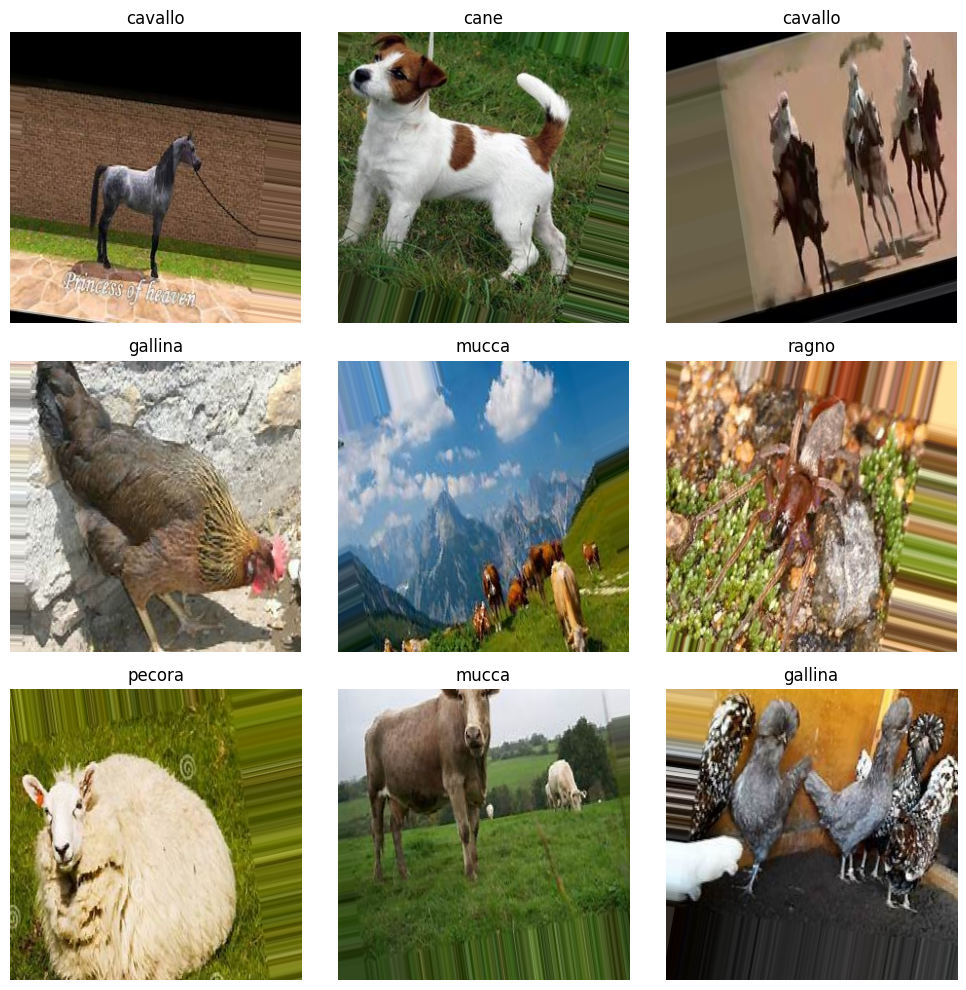

In [2]:
# Set up data directories and parameters
data_dir = 'data/animals10_dataset/raw-img'
img_height, img_width = 299, 299  # Inception V3 input size
batch_size = 32

# Get class names
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_classes = len(class_names)

print(f"Found {num_classes} classes: {class_names}")

# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Set up data generator for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Display some sample images from the dataset
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        # Undo preprocessing to display the image
        img = image_batch[i].astype("uint8")
        plt.imshow(img)
        label = np.argmax(label_batch[i])
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a batch of images
images, labels = next(train_generator)
# Convert preprocessed images back to displayable format
display_images = ((images * 0.5 + 0.5) * 255).astype('uint8')
show_batch(display_images, labels, class_names)


## 3. Implement Inception V3 Architecture

Now we'll implement the Inception V3 architecture using TensorFlow and Keras. We'll use the pre-trained Inception V3 model from Keras applications and fine-tune it for our specific task.


In [3]:
def create_inception_v3_model(input_shape=(299, 299, 3), num_classes=10):
    """
    Creates an Inception V3 model using TensorFlow/Keras.

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: Number of output classes

    Returns:
        A compiled Keras model with Inception V3 architecture
    """
    # Load the pre-trained Inception V3 model without the top classification layer
    base_model = InceptionV3(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Exclude the top classification layer
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model on top
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add a global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Add a fully connected layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Add output layer with softmax activation
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Combine inputs and outputs to create the model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configure device strategy for training
coreml_model_path = None

try:
    # First check if Neural Engine is available on Apple Silicon
    if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"]:
        print("Apple Silicon with Neural Engine detected")

        # For training, we still use MPS as Core ML is primarily for inference
        if tf.config.list_physical_devices('GPU'):
            # Set the device to MPS for training
            with tf.device('/device:MPS:0'):
                # Create the Inception V3 model
                model = create_inception_v3_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
                print("Model created on MPS device for training")
        else:
            # Fall back to CPU
            model = create_inception_v3_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on CPU (MPS not available)")
    elif tf.config.list_physical_devices('GPU'):
        # MPS available but no Neural Engine
        with tf.device('/device:MPS:0'):
            model = create_inception_v3_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on MPS device")
    else:
        # Fall back to CPU or CUDA GPU if available
        model = create_inception_v3_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
        print("Model created on CPU or CUDA GPU")
except Exception as e:
    print(f"Error setting device: {e}")
    # Fall back to default device
    model = create_inception_v3_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
    print("Model created on default device due to error")

# Display model summary
model.summary()


Apple Silicon with Neural Engine detected
Model created on MPS device for training


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,911,210 (91.21 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

## 4. Fine-tune the Inception V3 Model

Now we'll fine-tune the Inception V3 model on the Animals10 dataset. We'll first train only the top layers, and then unfreeze some of the Inception V3 layers for fine-tuning.


In [4]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('/models/inception_v3_animals10_best.keras', save_best_only=True)
]

# Train the model (only the top layers)
initial_epochs = 10
start_time = time.time()

# Configure training to use MPS device if available
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Training with MPS (Apple Silicon GPU)")
        # Use MPS device for training
        with tf.device('/device:MPS:0'):
            history = model.fit(
                train_generator,
                epochs=initial_epochs,
                validation_data=validation_generator,
                callbacks=callbacks
            )
    else:
        # Fall back to CPU or CUDA GPU
        print("Training with CPU or CUDA GPU")
        history = model.fit(
            train_generator,
            epochs=initial_epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )
except Exception as e:
    print(f"Error setting device for training: {e}")
    # Fall back to default device
    print("Training with default device due to error")
    history = model.fit(
        train_generator,
        epochs=initial_epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

initial_training_time = time.time() - start_time
print(f"Initial training completed in {initial_training_time:.2f} seconds")

# Unfreeze the last few layers of the Inception V3 model for fine-tuning
base_model = model.layers[1]  # Get the base model
base_model.trainable = True

# Freeze all layers except the last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 2
total_epochs = initial_epochs + fine_tune_epochs
start_time = time.time()

# Configure fine-tuning to use MPS device if available
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Fine-tuning with MPS (Apple Silicon GPU)")
        # Use MPS device for fine-tuning
        with tf.device('/device:MPS:0'):
            fine_tune_history = model.fit(
                train_generator,
                epochs=total_epochs,
                initial_epoch=initial_epochs,
                validation_data=validation_generator,
                callbacks=callbacks
            )
    else:
        # Fall back to CPU or CUDA GPU
        print("Fine-tuning with CPU or CUDA GPU")
        fine_tune_history = model.fit(
            train_generator,
            epochs=total_epochs,
            initial_epoch=initial_epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )
except Exception as e:
    print(f"Error setting device for fine-tuning: {e}")
    # Fall back to default device
    print("Fine-tuning with default device due to error")
    fine_tune_history = model.fit(
        train_generator,
        epochs=total_epochs,
        initial_epoch=initial_epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

fine_tuning_time = time.time() - start_time
print(f"Fine-tuning completed in {fine_tuning_time:.2f} seconds")

# Combine the history objects
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])

# Save the final model
model.save('models/inception_v3_animals10_final.keras')


Training with MPS (Apple Silicon GPU)


/Users/dos/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 388s 559ms/step - accuracy: 0.8093 - loss: 0.6628 - val_accuracy: 0.9755 - val_loss: 0.0873 - learning_rate: 1.0000e-04
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 718s 1s/step - accuracy: 0.9520 - loss: 0.1632 - val_accuracy: 0.9746 - val_loss: 0.0878 - learning_rate: 1.0000e-04
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 965s 1s/step - accuracy: 0.9540 - loss: 0.1519 - val_accuracy: 0.9782 - val_loss: 0.0772 - learning_rate: 1.0000e-04
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 371s 565ms/step - accuracy: 0.9610 - loss: 0.1347 - val_accuracy: 0.9774 - val_loss: 0.0783 - learning_rate: 1.0000e-04
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 361s 549ms/step - accuracy: 0.9589 - loss: 0.1418 - val_accuracy: 0.9763 - val_loss: 0.0823 - learning_rate: 1.0000e-04
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 349s 531ms/step - accuracy: 0.9617 - loss: 0.1338 - val_accuracy: 0.9778 - val_loss: 0.0779 - learning_rate: 1.0000e-04
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 269s 4

## 5. Evaluate the Model

Let's evaluate the trained model on the validation set.


In [5]:
# Evaluate the model
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Evaluating with MPS (Apple Silicon GPU)")
        # Use MPS device for evaluation
        with tf.device('/device:MPS:0'):
            evaluation = model.evaluate(validation_generator)
    else:
        # Fall back to CPU or CUDA GPU
        print("Evaluating with CPU or CUDA GPU")
        evaluation = model.evaluate(validation_generator)
except Exception as e:
    print(f"Error setting device for evaluation: {e}")
    # Fall back to default device
    print("Evaluating with default device due to error")
    evaluation = model.evaluate(validation_generator)

print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# After training is complete, convert to Core ML if on Apple Silicon with Neural Engine
if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"]:
    try:
        import coremltools
        print("Converting trained model to Core ML format for Neural Engine acceleration")
        coreml_model_path = convert_to_coreml(model, (img_height, img_width, 3), class_names)
    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        coreml_model_path = None
    except Exception as e:
        print(f"Error converting to Core ML: {e}")
        coreml_model_path = None

# Get predictions for the validation set
validation_generator.reset()
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Predicting with MPS (Apple Silicon GPU)")
        # Use MPS device for prediction
        with tf.device('/device:MPS:0'):
            y_pred = model.predict(validation_generator)
    else:
        # Fall back to CPU or CUDA GPU
        print("Predicting with CPU or CUDA GPU")
        y_pred = model.predict(validation_generator)
except Exception as e:
    print(f"Error setting device for prediction: {e}")
    # Fall back to default device
    print("Predicting with default device due to error")
    y_pred = model.predict(validation_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


Evaluating with MPS (Apple Silicon GPU)
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.9809 - loss: 0.0733


When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html


Validation Loss: 0.0639
Validation Accuracy: 0.9815
Converting trained model to Core ML format for Neural Engine acceleration
Converting TensorFlow model to Core ML format...
Error converting to Core ML: 'Functional' object has no attribute '_get_save_spec'
Predicting with MPS (Apple Silicon GPU)
164/164 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.98      0.98      0.98       972
     cavallo       0.99      0.97      0.98       524
    elefante       0.98      0.99      0.98       289
    farfalla       0.99      0.99      0.99       422
     gallina       0.99      1.00      0.99       619
       gatto       0.99      0.95      0.97       333
       mucca       0.95      0.97      0.96       373
      pecora       0.96      0.96      0.96       364
       ragno       0.99      0.99      0.99       964
  scoiattolo       0.98      0.99      0.98       372

    accuracy                          

## 6. Visualize the Results

Let's visualize the training progress and model performance.


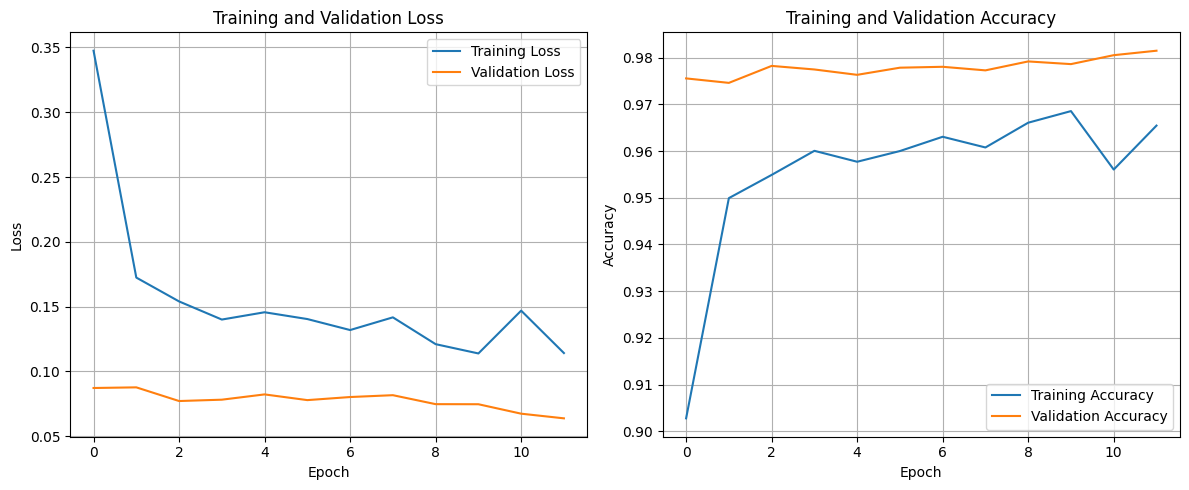

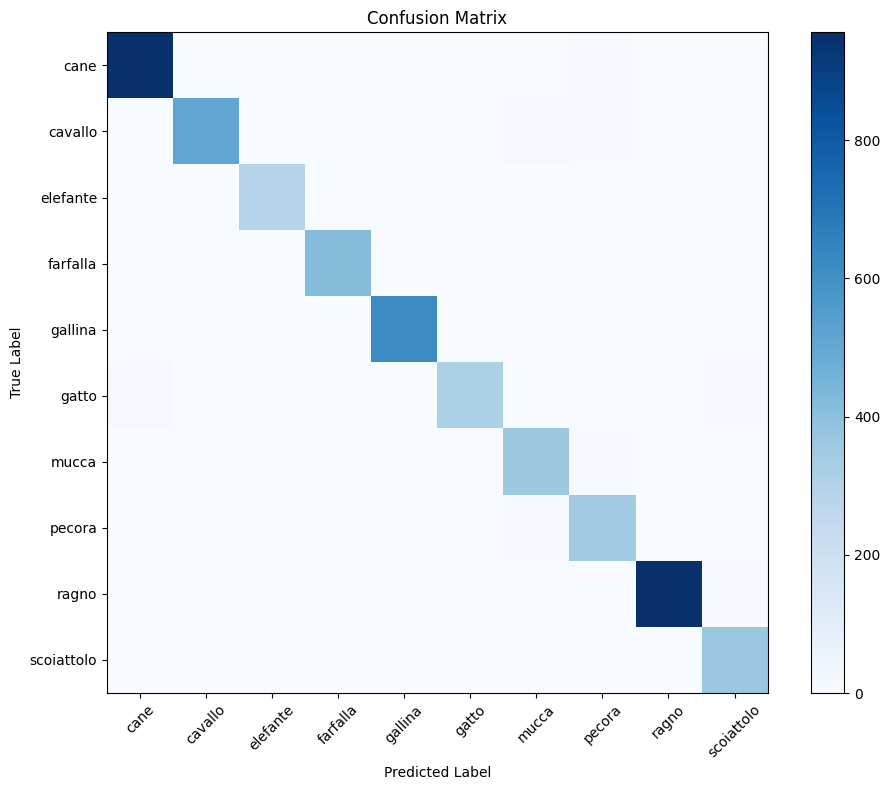

In [6]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 7. Image Analysis Application

Now let's create a function to analyze new images using our trained model.


Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


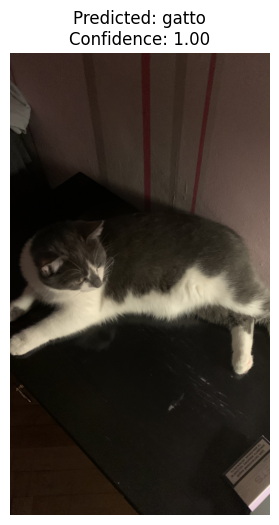

Predicted class: gatto
Confidence: 1.00


In [7]:
def analyze_image(image_path, model, class_names):
    """
    Analyze an image using the trained Inception V3 model.

    Args:
        image_path: Path to the image file
        model: Trained Inception V3 model
        class_names: List of class names

    Returns:
        Predicted class and confidence score
    """
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img_array = np.array(img)

    # Handle grayscale images
    if len(img_array.shape) == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)

    # Handle RGBA images
    if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    # Expand dimensions to create a batch
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Make prediction
    try:
        # Check if MPS is available
        if tf.config.list_physical_devices('GPU'):
            print("Predicting with MPS (Apple Silicon GPU)")
            # Use MPS device for prediction
            with tf.device('/device:MPS:0'):
                predictions = model.predict(img_array)
        else:
            # Fall back to CPU or CUDA GPU
            print("Predicting with CPU or CUDA GPU")
            predictions = model.predict(img_array)
    except Exception as e:
        print(f"Error setting device for prediction: {e}")
        # Fall back to default device
        print("Predicting with default device due to error")
        predictions = model.predict(img_array)

    # Get the predicted class and confidence
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    predicted_class = class_names[predicted_class_index]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

test_image_path = 'data/cat.jpg'
predicted_class, confidence = analyze_image(test_image_path, model, class_names)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")


## 8. Conclusion

In this lab, we implemented the Inception V3 architecture for animal image classification. We:

1. Loaded and preprocessed the Animals10 dataset
2. Implemented the Inception V3 architecture using TensorFlow/Keras
3. Trained and fine-tuned the model on the dataset
4. Evaluated the model's performance
5. Created a function to analyze new images

The Inception V3 architecture, with its efficient use of asymmetric filters and 1x1 convolutions, provides excellent performance for image classification tasks while minimizing computational costs.
